# Full Stack Quantum Computing
### QFT and AQFT Addition | Qiskit and Python

In [1]:
# Importing standard Qiskit libraries
from qiskit import *

provider = IBMQ.load_account()

In [2]:
from qiskit.visualization import plot_histogram

In [3]:
import numpy as np
import math
import operator
import cmath
import random

# Introduction

A Quantum Computer is a physical device that exploits quantum states to perform various computations expressed as mathematical probability models. The Quantum Fourier Transform (QFT) is one of the most important computational operations in quantum computing which facilitates efficient usage of resources. The periodicity encoded in the amplitudes within a quantum state can be observed and exploited for application in quantum algorithms such as: factoring and for computing the discrete logarithm, for quantum phase estimation and solving the hidden subgroup problem [1]. 

Quantum information is volatile and the implmentation of large quantum algorithms are suseptible to errors due to decoherence. The implementation of fault-tolerant computation processes is vital in achieving error free results. Fault tolerance mitigates errors at the expense of utilizing  multiple qubits to essentially encode a single logical qubit. The implementation of a fault-tolarent n-qubit AQFT relies on approximating the desired transformation by removing small-angle controlled rotations to improve gate count. 


<!-- from $O(n^2)$ to $O(nlog(n))$. -->

Our presentation starts with a brief introduction to basic quantum properties. This is followed by a mathematical introduction to the discrete Fourier transform which is followed by the description of its quantum implementation in terms of quantum networks. Then we analyse how the performance of the QFT in the periodicity estimation is affected by the approximations in the algorithms and by decoherence. We also comment on possible simplifications in practical implementations of quantum networks effecting the QFT and AQFT.

# Background

<!-- A qubit is a two–state quantum system; it has a chosen ‘computational basis’
{|0i, |1i} corresponding to the classical bit values 0 and 1. Boolean operations
which map sequences of 0’s and 1’s into another sequences of 0’s and 1’s are
defined with respect to this computational basis. A collection of L qubits is
called a register of size L. -->

<!-- Information is stored in the registers in binary form. For example, number 6 is
represented by a register in state |1i ⊗ |1i ⊗ |0i. In more compact notation: |ai
stands for the direct product |a L−1 i ⊗ |a L−2 i . . . |a 1 i ⊗ |a 0 i which represents a
quantum register prepared with the value a = 2 0 a 0 + 2 1 a 1 + . . . 2 L−1 a L−1 . -->


<!-- Information is stored in the registers in binary form. Let $a_n a_{n-1} ... a_2a_1$ be the binary representation of a, where $a = a_n2^{n-1}+ a_{n-1}2^{n-1}+...+ a_12^0$. Therefore $|a\rangle = |a_n\rangle \otimes |a_{n-1}\rangle \otimes...\otimes |a_2\rangle \otimes |a_1\rangle$ -->

A quantum logic gate is an elementary quantum computing device which performs a fixed unitary operation on selected qubits in a fixed period of time [1].

A quantum network is a quantum computing device consisting of quantum
logic gates whose computational steps are synchronised in time. The outputs
of some of the gates are connected by wires to the inputs of others. The size
of the network is its number of gates [2].

A quantum computer will be viewed here as a quantum network (or a family of
quantum networks). Quantum computation is defined as a unitary evolution of
the network which takes its initial state “input” into some final state “output” [2].

# The Quantum Gate

Quantum gate are the logical units in quantum computing and are implemented as unitary matrix operations that perform rotational manipulations in the Bloch Sphere. Unitary matrices simply perform transformations on qubits while preserving the angle between them. Quantum gates can operate on one or more states [1]. The action of a quantum gate on a single qubit is defined as a matrix mulitplication of the unitary matrix and vector as illustrated below

$$\left|\psi'\right\rangle = U\left|\psi\right\rangle$$

where $U$ represents a unitary matrix relative to some basis, in this case the computational bases. A gate that acts on $n$ qubits is represented by a $2^n x 2^n$ unitary matrix. An infinite number of gates are possible, the most common gates will be explored. This will be used as building blocks to construct more complex gates [1,2].

>#### The Phase shift Gates
> The phase shift gate maps the basis states $|0\rangle \rightarrow |0\rangle$ and $|1\rangle \rightarrow e^{i\varphi}|1\rangle$. The gate is defined by the following matrix

>$$
P(\varphi)   =
\begin{pmatrix}
1 & 0\\
0 & e^{i\varphi}
\end{pmatrix}
$$

> This gate defines a rotation around the Bloch sphere specified by $\varphi$. It performs a rotation of $\varphi$ around the Z-axis. This simply means that it leaves the probability of measuring $|0\rangle$ or $|1\rangle$ unchanged but modifies the phase [2].

>#### The Hamard Gates
>The Harmad gate is a single qubit gate that transforms the bases states within the Block sphere, it is defined by ,

>$$
H   = \frac{1}{\sqrt2}  
\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}=  U(0,\pi)
$$

> This gate defines a rotation around the Bloch sphere. It maps the basis state $|0\rangle$ $\rightarrow$ $\frac{|0\rangle + |1\rangle}{\sqrt(2)}$ and $|1\rangle$ $\rightarrow$ $\frac{|0\rangle - |1\rangle}{\sqrt(2)}$. This simply means that the measurement will have probabilities also known as superposition. This is represented as a $\pi$ rotation about the $\frac{x+z}{\sqrt2}$ axis on the Block sphere [1,2]. 

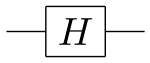

>#### The Identity Gate
>The identity gate is a single qubit gate that leaves the bases states unchanged 

>$$
I   =  
\begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}
$$

> This gate defines  a none operation on a state. It is useful for error checking on hardware and some basic operation validation i.e. a single qubit gate is it's own inverse [1,2].

>### The Controlled Quantum Gate
Controlled type gates perform action dependent operation. More specifically a controlled two-qubit gate $C_{U}$ applies a unitary $U$ to a second qubit when the state of the first is $\left|1\right\rangle$, where $C_{U}$ 

>$$\begin{equation}
	C_U = \begin{pmatrix}
	1 & 0 & 0 & 0 \\
	0 & u_{00} & 0 & u_{01} \\
	0 & 0 & 1 & 0 \\
	0 & u_{10} &0 & u_{11}
		\end{pmatrix}.
\end{equation}$$

>when the `control` is the MSB and

>$$\begin{equation}
	C_U = \begin{pmatrix}
	1 & 0 & 0  & 0 \\
	0 & 1 & 0 & 0 \\
	0 & 0 & u_{00} & u_{01} \\
	0 & 0 & u_{10} & u_{11}
		\end{pmatrix}.
\end{equation}$$


>when the `control` is the LSB [1,2]


>### The Swap Gate

The simpliest of the 2 qubit gates is the swap gate. It essentially exchanges two qubits. It's matrix representation is defined by


>$$\begin{equation}
	SWAP = \begin{pmatrix}
	1 & 0 & 0 & 0 \\
	0 & 0 & 1 & 0 \\
	0 & 1 & 1 & 0 \\
	0 & 0 &0 & 1
		\end{pmatrix}.
\end{equation}$$

>This gate transforms the basis $|01\rangle$ to $|10\rangle$ etc []. There circuit representation is shown below.

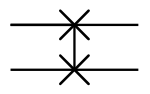


This operation can be simplified further by employing a conditional (controlled) rotation gate. If the control bit has a zero probability of being in the state $|1\rangle$, the target remains the same. This is equivalent to when the exponent factor in the QFT is zero, the coefficient remain unchanged [2,3]. The gates needed to perform the QFT and their corresponding matrices are illustrated below


>### The Conditional Rotation Gate
The controlled-phase, denoted $R_k$, is mathematically represented below,

>$$
R_k= 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & e^{\frac{\pi}{2^k}}\\
\end{pmatrix}. 
$$

>This gate performs a conditional phase rotation between two qubits conditioned on their superposition.



## The Quantum Fourier Transform

The QFT is an application of the common classical Discrete Fourier Transform (DFT) to the quantum states[3,4]. The DFT performs computations on a vector, with each element a measured representing a probability. This can be expressed as,


$$
y_k = \frac{1}{\sqrt N}\sum\limits_{j=0}^{N-1} x_{j}e^{\frac{2 \pi i k j}{N}}
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$


The QFT of state $|x \rangle$ from the computational basis $|0\rangle , |1\rangle, ...|N-1\rangle$ can be expressed as follows.

$$
QFT|x\rangle = \frac{1}{\sqrt N}\sum\limits_{y=0}^{N-1}e^{\frac{2 \pi i x y}{N}}|y\rangle
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$

Alternatively, a more compact expression is defined as,

$$
 F(\Psi) =\frac{1}{\sqrt N}\sum\limits_{j=0}^{N-1} \Psi_{j}e^{\frac{2 \pi i k j}{N}}
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$


Consider the 1 qubit state $|\Psi\rangle = \alpha|0 \rangle + \beta | 1 \rangle$.


$$
 F(\Psi) =\frac{1}{\sqrt 2}\sum\limits_{j=0}^{1} \Psi_{j}e^{\frac{2 \pi i k j}{2}}
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$

Simplifying yields:


$$
 F(\Psi_{0}) =\frac{\alpha + \beta}{\sqrt 2}
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$

and 

$$
 F(\Psi_{1}) =\frac{\alpha - \beta}{\sqrt 2}
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$


The resulting state is expressed as follows:

$$
QFT|\Psi\rangle = \frac{1}{\sqrt 2}(\alpha+\beta)|0\rangle + \frac{1}{\sqrt 2}(\alpha - \beta)|1\rangle
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$


Representing this in matrix form, the 1 qubit QFT results in,

$$
 M^{2x2} 
\begin{pmatrix}
\alpha \\
\beta \\
\end{pmatrix}
= \frac{1}{\sqrt 2} 
\begin{pmatrix}
\alpha + \beta\\
\alpha - \beta\\
\end{pmatrix}
$$


Solving for the matrix M yields,

$$
 M =\frac{1}{\sqrt 2}
\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}
$$

This is the Hadamard matrix. To verify, the $H$ operator is applied to the state $|\Psi\rangle = \alpha|0 \rangle + \beta | 1 \rangle$, the new state obtained is 


$$
            H \otimes |\Psi \rangle = \frac{1}{\sqrt 2}(\alpha+\beta)|0\rangle) + \frac{1}{\sqrt 2}(\alpha-\beta)|1\rangle)
$$





Similarly a 2 qubit state, $|\Psi\rangle = \alpha|00 \rangle + \beta|01 \rangle + \gamma|10\rangle + \zeta|11\rangle$  can be derived as follows:
 
 $$
 F(\Psi) =\frac{1}{2}\sum\limits_{j=0}^{3} \Psi_{j}e^{\frac{2 \pi i k j}{4}}
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$
 
 
 Calculating the QFT of this state is as follows:
 
 
$$
 |F(\Psi_{0})\rangle =\frac{\alpha + \beta + \gamma + \zeta}{ 2}|00\rangle
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$

and 

$$
|F(\Psi_{1})\rangle =\frac{\alpha + \beta e^{\frac{\pi i}{2}} + \gamma e^{\pi i} + \zeta e^{\frac{3 \pi i}{2}}   }{2}|01\rangle
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$

and 

$$
|F(\Psi_{2})\rangle =\frac{\alpha + \beta e^{\pi i} + \gamma e^{2 \pi i} + \zeta e^{3 \pi i}} {2}|10\rangle
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$

and 

$$
|F(\Psi_{3})\rangle =\frac{\alpha + \beta e^{\frac{3 \pi i}{2}} + \gamma e^{3\pi i} + \zeta e^{\frac{9 \pi i}{2}}}{2}|11\rangle
% \begin{pmatrix}
% 1 & 0\\
% 0 & e^{i\varphi}
% \end{pmatrix}
$$


The matrix representation of the 2 qubit QFT is as follows:




$$
M^{4x4} 
\begin{pmatrix}
\alpha \\
\beta \\
\gamma \\
\zeta 
\end{pmatrix}
=\frac{1}{2}
\begin{pmatrix}
\alpha & \beta                       &  \gamma              &  \zeta                         \\
\alpha & \beta e^{\frac{\pi i}{2}}   &  \gamma e^{\pi i}    &  \zeta e^{\frac{3 \pi i}{2}}  \\
\alpha & \beta e^{\pi i}             &  \gamma e^{2 \pi i}  &  \zeta e^{3 \pi i}          \\
\alpha & \beta e^{\frac{3 \pi i}{2}} &  \gamma e^{3\pi i}   &  \zeta e^{\frac{9 \pi i}{2} } 
\end{pmatrix}
$$




Solving for the matrix M yields,

$$
 M =\frac{1}{ 2}
\begin{pmatrix}
1 &  1 &  1 &  1\\
1 &  i & -1 & -i\\
1 & -1 &  1 & -1\\
1 & -i & -1 &  i\\
\end{pmatrix}
$$


The rotations are equivalent to performing a series of operations of the form $e^{i\theta}$, where $\theta$ takes on different values as illustrated below.


$$
\theta= \frac{2\pi}{2^k} = \frac{\pi}{2^{k-1}}
$$

Thus the obtained matrices for 1 qubit and 2 qubit can be defined as 

$$
 M =\frac{1}{\sqrt 2}
\begin{pmatrix}
e^{0i} & e^{0i}\\
e^{0i} & e^{\pi i}
\end{pmatrix}
$$


and

$$
 M =\frac{1}{2}
\begin{pmatrix}
e^{0i} & e^{0i} & e^{0i} & e^{0i}\\
e^{0i} & e^{\frac{\pi}{2}i} & e^{\pi i} & e^{\frac{3 \pi}{2}i}\\
e^{0i} & e^{\pi i} & e^{2 \pi i} & e^{3 \pi i}\\
e^{0i} & e^{\frac{3 \pi}{2}i} & e^{3 \pi i} & e^{\frac{9 \pi}{2}i}\\
\end{pmatrix}
$$

respectively.

Thus, the equation 

 $$
 F(\Psi) =\frac{1}{\sqrt N}\sum\limits_{j=0}^{N-1} \Psi_{j}e^{\frac{2 \pi i k j}{N}}
 $$
 
 and 
 
 $$
 M =\frac{1}{\sqrt N}
\begin{pmatrix}
e^{\frac{0 \times  \pi i}{N}} & e^{\frac{0 \times \pi i}{N}} & ... & e^{\frac{0 \times \pi i}{N}}\\
e^{\frac{0 \times  1\pi i}{N}}  & e^{\frac{1 \times 1 \pi i}{N}} &...& e^{\frac{(N-1) \times 1 \pi i}{N}}\\
\vdots & \vdots & \vdots & \vdots \\
e^{\frac{0 \times (N-1)\pi i}{N}} & e^{\frac{1 \times (N-1)\pi i}{N}} & ... &e^{\frac{(N-1)(N-1)\pi i}{N}}\\
\end{pmatrix}
$$
 
represents an N-dimentional Quantum Fourier Transform!








 

<!-- Information is stored in the registers in binary form. For example, number 6 is
represented by a register in state |1i ⊗ |1i ⊗ |0i. In more compact notation: |ai
stands for the direct product |a L−1 i ⊗ |a L−2 i . . . |a 1 i ⊗ |a 0 i which represents a
quantum register prepared with the value a = 2 0 a 0 + 2 1 a 1 + . . . 2 L−1 a L−1 . -->


Information is stored in the registers in binary form. Let $a_n a_{n-1} ... a_2a_1$ be the binary representation of a, where $a = a_n2^{n-1}+ a_{n-1}2^{n-1}+...+ a_12^0$. Therefore $|a\rangle = |a_n\rangle \otimes |a_{n-1}\rangle \otimes...\otimes |a_2\rangle \otimes |a_1\rangle$ [2,3].

 Decomposing the matrix into a series of rotations, where each rotation can be implemented using the quantum conditional rotation gate presented in section I. It can be observed that by combining a number of phase gates with different values of $\varphi$, any rotation around the sphere can be obtained.


For example, given a 2 qubit state  $|\Psi\rangle = \alpha|00 \rangle + \beta|01 \rangle + \gamma|10\rangle + \zeta|11\rangle$ after the transformation will result in a joint state  $|\Psi\rangle = \alpha|00 \rangle + \beta|01 \rangle + \gamma|10\rangle + e^{\frac{\pi}{2^{k-1}}} \zeta|11\rangle$

The Quantum Fourier Transform circuit is developed as follows, apply the Hadamard gate on the qubit from n. With each iteration apply $n-index$ controlled rotation gates with phase of $\frac{\pi}{2^{n-index}}$. The figure below illustrates the QFT   $|a\rangle$ $\rightarrow |\phi \rangle$, where the left is the input state and the right is the output state after the postulate evolution. 


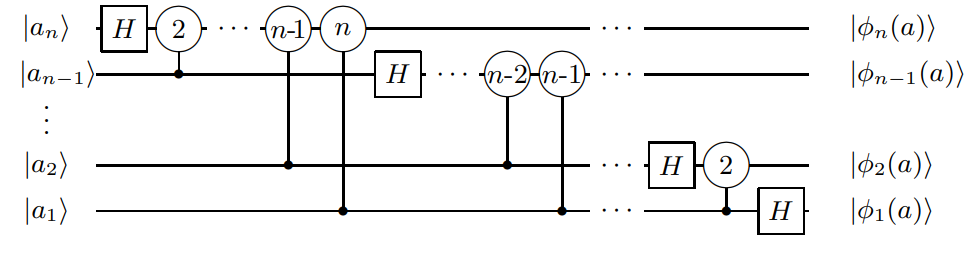Figure 1: Quantum Fourier Transform [5].




This demonstrates a QFT for $N=2^n$. Only the last qubit depends on the value of all the other input qubits and each further qubit depends less and less on the input qubits. All this to mean that entanglement deteriorates as distance coupling increases [4]. The Qft() function below implements the transformation  described above.

In [4]:
def Qft(qc, reg, n):
    """
    Computes the quantum Fourier transform of reg, one qubit at
    a time.
    """
    if n == 0:
        return circuit

    qc.h(reg[n])
    for i in range(0, n):
        qc.cp(math.pi/float(2**(i+1)), reg[n-(i+1)], reg[n])
    qc.draw()

## The Inverse QFT

By using the reversibility properties of quantum states, the Inverse Quantum Fourier Transform (IQFT) is achieved by applying the QFT in reverse.

In [5]:
def inverseQFT(qc, reg, n):
    """
    Performs the inverse quantum Fourier transform on a register reg.
    Apply repeated phase rotations with parameters being pi divided by
    decreasing powers of two, and then apply a Hadamard gate to the nth qubit
    of the register reg.
    """
    for i in range(0, n):
        qc.cp(-1*math.pi/float(2**(n-i)), reg[i], reg[n])
    qc.h(reg[n])

## QFT Addition

The quantum addition is performed by employing a sequence of mutually commutative conditional rotations []. The difference is that unlike the QFT, the rotations are conditioned on $n$ external bits. This means that addition can be performed on quantum data based on classical data. The figure below illustrates the operations used to achieve the addition of $|\phi \rangle + |b\rangle$, where $|\phi \rangle$ is the evolved QFT state of $|a\rangle$ and $|b\rangle$ is the second number.


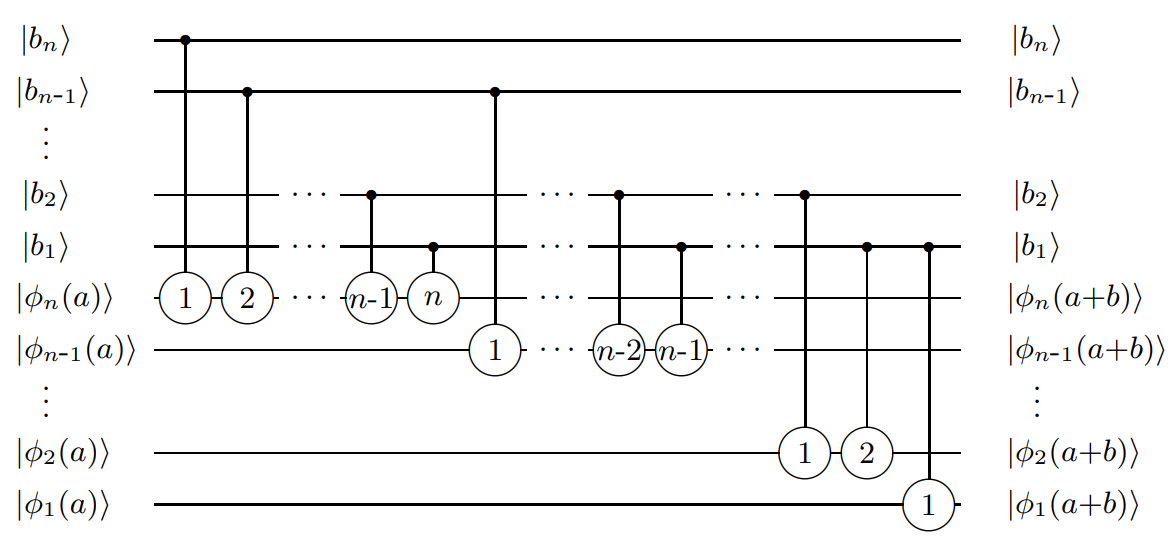Figure 2: Quantum Fourier Tranform Adder [5].


The addition is achieved by performing quantum counting conditioned on the computational basis of $|b\rangle$. This simply means that the rotations of $|b\rangle$ are added to $\phi(a)\rangle$. The state $|F(\Psi(a))\rangle$ evolves to $|F(\Psi(a + b))\rangle$.  The implementation is illustrated below.

In [6]:
def evolveQFTState(qc, reg_a, reg_b, n):
    """
    Evolves the state |F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))> using the quantum
    Fourier transform conditioned on the qubits of the reg_b.
    """
    for i in range(0, n+1):
        qc.cp(math.pi/float(2**(i)), reg_b[n-i], reg_a[n])


The transformation of a single qubit is illustrated as follows:

 $$
 |\phi_n(a)\rangle \rightarrow \frac{1}{\sqrt2}(|0\rangle + e(0.a_na_{n-1}...a_1+0.b_n)|1\rangle)              
 $$
 
 
  $$
 |\phi_n(a)\rangle \rightarrow \frac{1}{\sqrt2}(|0\rangle + e(0.a_na_{n-1}...a_1+0.b_nb_{n-1})|1\rangle)
 $$
 
 $$\vdots$$
 
  $$
 |\phi_n(a)\rangle \rightarrow \frac{1}{\sqrt2}(|0\rangle + e(0.a_na_{n-1}...a_1+0.b_n...b_1)|1\rangle)
 $$
 
 $$
 |\phi_n(a)\rangle \rightarrow |\phi_n(a+b)\rangle
 $$

where $e(0.a_n...a_1) = e(\frac{a}{2^n})$ ,$ e = e^{2 \pi i k }$ , and $(0.a_n...a_1)$ is a binary fraction.

Finally the IQFT is employed to convert the evolved state $|F(\Psi(a + b))\rangle$ $\rightarrow$ $(a+b)$. The full implementation is presented below.

## The Qiskit QFT Adder

In [7]:
def QftAdder(qc, a, b, cl, n):

    for i in range(0, n+1):
        Qft(qc, a, n-i)

    #Add the two numbers by evolving the Fourier transform F(ψ(a))> to |F(ψ(a+b))>
    for i in range(0, n+1):
        evolveQFTState(qc, a, b, n-i)

    #Compute the inverse Fourier transform of register a
    for i in range(0, n+1):
        inverseQFT(qc, a, i)


    #Measure qubits
    circuit = measure(qc, a, cl, n)

    num_shots = 256
    job = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shot = num_shots)
    qasm_result = job.result().get_counts()
    print("The measured Probabilities are:\n")
    print(qasm_result)
    #Select result with maximum probabilities
    print("\nThe result with the maximum probability:\n")
    output = max(qasm_result.items(), key=operator.itemgetter(1))[0]
    print(int(output,2))
    
    return qasm_result

The following documents the utility functions that support the implementation of the QFT Adder above.

> ## Input Request

> The input function simply requests integer numbers to be added, validates, and converts them to binary.


> #### Qiskit Version

In [8]:
def inputRequest():

    valid = False

    while not valid:
        first_number = input("Enter first integer number: ")
        second_number = input("Enter second integer number: ")

        if len(first_number) > 10 or len(second_number) > 10:
            print("Invalid input. Try again")
        else: valid = True

    first_number = integer_to_binary(int(first_number))
    second_number = integer_to_binary(int(second_number),len(first_number))

    print("first Number: "+first_number+" second Number: "+second_number)
    return first_number, second_number, len(first_number)

> #### Python Version

In [9]:
def inputRequestClassic():

    valid = False

    while not valid:
        first_number 	= input("Enter first integer number: ")
        second_number 	= input("Enter second integer number: ")

        if len(integer_to_binary(int(first_number))) > 1023 or len(integer_to_binary(int(second_number))) > 1023:
            print("Invalid input. Try again")
        else: valid = True




    first_number = integer_to_binary(int(first_number), len(integer_to_binary(int(first_number)))+1)
    second_number = integer_to_binary(int(second_number),len(integer_to_binary(int(second_number)))+1)

    print("first Number: "+first_number+" second Number: "+second_number)

    return first_number, second_number


> ## Conversion

> The function below converts integers to binary while providing padding functionality. This ensures that the numbers are the correct length to perform operation on.

> #### Integer to Binary

In [10]:
def integer_to_binary(number, dimensionality=-1):
    """Convert an integer number to a bit string
    """
    bit_str = bin(number)[2:]
    if dimensionality > 0:
        missing_leading_zeros = dimensionality - len(bit_str)
        bit_str = "0" * missing_leading_zeros + bit_str

    return bit_str

> #### Dirac Notation

In [11]:
def int_to_dirac_str(number, dimensionality=-1):
    """Convert an integer number to a bit string in Dirac Notation
    """

    DIRAC_STR = "|%s>"
    bit_str = integer_to_binary(number, dimensionality)
    return DIRAC_STR % bit_str

> #### State to Integer

In [12]:
def state_to_int(qu_state):
    """Return an integer for a pure state.
    |000> -> 0 or |010> -> 2. 
    """
    index = 0
    for element in qu_state.ket:
        if element:
            return index
        index += 1

    return None

> ## Initialisation of Quantum Registers and Circuit
Two functions are provided to initialise the registers needed to perform the arithmetic operations. First the registers needed are initialised with the appropriate number of qubits. The circuit is constructed using the registers.


In [13]:
def registerInit(n):
    a = QuantumRegister(n+1, "a")
    b = QuantumRegister(n+1, "b")
    cl = ClassicalRegister(n+1, "cl")
    qc = QuantumCircuit(a, b, cl, name="qc")

    return qc, cl, a, b

> Next, the binary numbers are initialised into the registers.

In [14]:
def quSet(first_number, second_number,a, b ,qc):

    count = 0
    for i in first_number:
            if i == "1": qc.x(a[len(first_number) - (count+1)])
            count+=1

    count = 0
    for i in first_number:
            if i == "1": qc.x(b[len(second_number) - (count+1)])
            count+=1

    return qc, a, b

> ## Measurement

> The methods below facilitates measurement of the entire circuit.


> #### Qiskit Version

In [15]:
def measure(qc, a, cl, n):
    for i in range(n+1):
        qc.measure(a[i],cl[i])
    return qc

> #### Python Version

In [16]:
def measurement_probability(amplitude):

        if amplitude:
            return (np.conjugate(amplitude) * amplitude).real
        return 0


## Unitary Simulation
<!-- The unitary simulation of the QFT adder is implemented in Python. Similar principles are employed. -->



> #### Properties of Quantum States
> The class for the base state is implemented as demonstrated below. It encapsulated the properties of a quantum state.

In [17]:
import abc
class QBaseState(abc.ABC):
    """Common properties of quantum states.
    
    """

    @property
    def ket(self):
        """Column vector representation of the quantum state"""
        return self._state

    @property
    def bra(self):
        """The Hermitian Conjugate of the state"""
        return np.conjugate(self._state.T)

    @abc.abstractmethod
    def __init__(self, state):
        self._state = state

> #### The Qubit 
The Qubit is represented as a two level system that inherits the quantum states. The implementation is demonstrated below.

In [18]:
class QBit(QBaseState):
    """A two level quantum system.
    Constants:
        ZERO: string representation of 0 qubit
        ONE : string representation of 1 qubit
        
    """

    ZERO = "0"
    ONE  = "1"


    def __init__(self, qubit_str):
        """initialize a QBit object from its string representation.
    
        """
        if qubit_str == QBit.ZERO:
            state = np.array([[1], [0]])
        elif qubit_str == QBit.ONE:
            state = np.array([[0], [1]])

        else:raise ValueError("A qubit must be one 0 or 1")

        super().__init__(state)
        self._state_str = qubit_str

> #### Qubit Initialisation

In [19]:
ZERO = QBit(QBit.ZERO)
ONE = QBit(QBit.ONE)

> #### The Quantum Gate

The Quantum Gate is represented using matrices. The gate class has defined properties and operations. The required gates, defined above, are implemented.

In [20]:
class QGate(object):
    """A general quantum gate.
    QGate is a representation of a quantum gate using complex numpy matrices.

    Attributes:
        matrix: the matrix representation of the gate
    """

    @property
    def matrix(self):
        """Return the matrix."""
        return self._matrix

    @property
    def dagger(self):
        """Return the Hermitian of the matrix."""
        return self._matrix.H


    def __init__(self, matrix, multiplier=0):
        """Create a quantum gate from a numpy matrix.

        Args:
            matrix: a complex typed numpy matrix
        """

        if matrix.dtype == np.dtype('complex128'):
            self._matrix = matrix
        else:
            self._matrix = matrix.astype('complex128')

        shape = self._matrix.shape
        if shape[0] != shape[1]:
            raise ValueError("Gate is not a square matrix")

        if multiplier:
            self._matrix = self._matrix * multiplier

        is_unitary = np.allclose(self._matrix.H * self._matrix, np.eye(shape[0]))

        if not is_unitary:
             raise ValueError("Gate is not unitary")

    def __mul__(self, other):
        """Override matrix multiplication operator on QGate objects."""
        if hasattr(other, "matrix"):
            return QGate(self.matrix * other.matrix)

        return QGate(self.matrix, other)

    def __rmul__(self, other):
        """Override multiplication operator. Supports other QGate or number"""
        if hasattr(other, "matrix"):
            return QGate(other.matrix * self.matrix)

        return QGate(self.matrix, other)



    @classmethod
    def String(cls, matrix_str, multiplier=0):
        """Create a quantum gate from a string.
        Args:
            matrix_str: the string representation of the quantum gate
        """
        matrix = np.matrix(str(matrix_str), dtype='complex128')
        return QGate(matrix, multiplier)



    @classmethod
    def Multiplication(cls, qu_gates):
        """ Create a quantum gate by multiplying existing gates
        Args:
            qu_gates: a list of QGates to multiply
        """
        if qu_gates:
            matrix = qu_gates[0].matrix
            for i in range(1, len(qu_gates)):
                if matrix.shape != qu_gates[i].matrix.shape:
                    raise ValueError("The matrices have different shapes")

                matrix = matrix * qu_gates[i].matrix

            return QGate(matrix)
        else:
            raise ValueError("No gates specified")


    @classmethod
    def Tensor(cls, qu_gates):
        """ Create a quantum gate by the tensor product of other gates
        """
        if qu_gates:
            matrix = np.matrix([1], dtype="complex128")
            for i in range(len(qu_gates) - 1, -1, -1):
                matrix = np.kron(qu_gates[i].matrix, matrix)

            return QGate(matrix)
        else:
            raise ValueError("No gates specified")

    @classmethod
    def Control(cls, qu_gate, control_qubit=1, target_qubit=2, num_qubits=2):
        """ Creates a CONTROL-U gate
        Args:
            control_qubit: index of the control bit.
            target_qubit: the index of the target bit
            num_qubits: total number of qubits,
        """

        """Perform some basic logic checks"""
        if num_qubits < 2:
            raise ValueError("control gates must operate on at least 2 qubits")

        if control_qubit == target_qubit:
            raise ValueError("control qubit must be different than target qubit")

        if control_qubit > num_qubits:
            raise ValueError("control qubit cannot be greater than total number of qubits")

        if target_qubit > num_qubits:
            raise ValueErrorr("target qubit cannot be greater than total number of qubits")

        index = 1


        control_mat = 1
        target_mat = 1

        while index <= num_qubits:
            if index == control_qubit:
                    control_mat = np.kron(control_mat, np.eye(2))
                    target_mat = np.kron(target_mat, qu_gate.matrix)

            elif index == target_qubit:
                    control_mat = np.kron(control_mat, ZERO.ket * ZERO.bra)
                    target_mat = np.kron(target_mat, ONE.ket * ONE.bra)

            else:
                control_mat = np.kron(control_mat, np.eye(2))
                target_mat = np.kron(target_mat, np.eye(2))

            index += 1

        control_gate = control_mat + target_mat
        return QGate(control_gate)



    @classmethod
    def Swap(cls, a, b, num_qubits):
        """
        Initialize a swap gate between two qubits a and b
        """
        control_ab = QGate.Control(X, a, b, num_qubits)
        control_ba = QGate.Control(X, b, a, num_qubits)

        matrix = control_ab.matrix * control_ba.matrix * control_ab.matrix
        return QGate(matrix)


    @classmethod
    def Phase(cls, k):
        """
        Initialize a phase gate R(k)
        :param k: the power of the phase exp(2pi*j / 2 ** k)
        """
        phase = (2 * cmath.pi * 1j) / (2**k)
        phase_matrix = np.matrix([[1, 0], [0, cmath.exp(phase)]], dtype="complex128")
        return QGate(phase_matrix)

> #### Quantum States

>The quantum state in the computational basis is defined along with it's properties. The state is initialised using a map of qubits. The state is initialised as a superposition assigned with the same amplitude probabilities.

In [21]:
class QState(QBaseState):
    """A general quantum state in the computational basis.
    """

    @property
    def hilbert_dimension(self):
        """The dimensionality of the associated Hilbert space"""
        return self._hilbert_dimension

    @property
    def num_qubits(self):
        """The number of qubits needed to represent the QuState"""
        return self._num_qubits

    def __init__(self, state_map, state_vector=None):
        """Create a QuState from a map."""

        if state_vector is not None:
            super().__init__(state_vector)
        elif state_map:
            for state_tuple in state_map.items():
                state_bit_str = state_tuple[0]
                amplitude = state_tuple[1]
                tmp = None
                for bit in state_bit_str[::-1]:
                    if tmp is None:
                        tmp = QBit(bit).ket
                    else:
                        tmp = np.kron(QBit(bit).ket, tmp)

                if state_vector is not None:
                    state_vector += (tmp * amplitude)
                else:
                    state_vector = (tmp * amplitude)
            super().__init__(state_vector)

        else:
            raise ValueError("Error Initiating")


        self._num_qubits = int(math.log(self._state.size, 2))
        self._hilbert_dimension = self._state.size

    @classmethod
    def State(cls, state_list):
        """Create an equiprobable superposition states

        This will create a QuState that is a superposition of the
        states specified in argument and will assign the same
        probability amplitude to all states.
        """

        state_map= {}


        if state_list:
            amplitude = 1 / math.sqrt(len(state_list))
            for state in state_list:
                state_map[state] = amplitude

        return cls(state_map)


    def measure(self, qustate_format=None):
        """Measure the QuState
        Measurement of the state will result in one of the possible outcomes
        with the given probability.
        """
        rand = random.random()
        start = 0
        index = 0
        for amplitude in self.ket:
            probability = measurement_probability(amplitude[0])
            if start <= rand <= start + probability:
                possibility = index
                self._collapse(possibility)
                if qustate_format == "bitstring":
                    return integer_to_binary(possibility, self._num_qubits)

                return int_to_dirac_str(possibility, self._num_qubits)
            start += probability
            index += 1

        return None

    def _collapse(self, state_int):
        """collapses the state to the specified state_str"""
        state_index = state_int
        index = 0
        for element in self._state:
            if index == state_index:
                element[0] = 1
            else:
                element[0] = 0

            index += 1


    def apply_gate(self, qu_gate, qubit_list=None):
        """
        Apply a QuGate to the entire state or a qubit
        
        """
        if not qubit_list:
            qubit_list = []
        dimension = qu_gate.matrix.shape[0]
        qu_gate_list = []
        if qubit_list:
            eye_gate = QGate(np.asmatrix(np.eye(2)))
            for bit in range(1, self._num_qubits + 1):
                if bit in qubit_list:
                    qu_gate_list.append(qu_gate)
                else:
                    qu_gate_list.append(eye_gate)

        else:
            qu_gate_list.append(qu_gate)
            while dimension < self._hilbert_dimension:
                qu_gate_list.append(qu_gate)
                dimension *= 2

        final_gate = QGate.Tensor(qu_gate_list)
        # make sure dimensions are same after this
        if final_gate.matrix.shape[0] != self._hilbert_dimension:
            raise RuntimeError("gate of dimension %s cannot be applied to"
                               "state with dimension %s" %
                               (final_gate.matrix.shape[0],
                                self._hilbert_dimension))

        self._state = np.asarray(final_gate.matrix * self._state)

        print (self._state)



    def __str__(self):
        """Dirac notation of qubit """
        my_str = []
        index = 0
        for element in self.ket:
            if element:
                if my_str:
                    my_str.append(" + ")
                my_str.append(self._amplitude_str(element[0]))
                bit_str = int_to_dirac_str(index, self._num_qubits)
                my_str.append(bit_str)
            index += 1
        return "".join(my_str)



    def _amplitude_str(self, amplitude):
        if amplitude.real and not amplitude.imag:
            return str(amplitude.real)
        if amplitude.imag and not amplitude.real:
            return str(amplitude.imag) + "j"

        return str(amplitude)





    def possible_measurements(self, qubit_index=-1):
        """
        Returns all possible measurements and their probability.
        
        """
        states_map = {}
        index = 0
        for element in self.ket:
            if element:
                probablility = measurement_probability(element[0])
                dirac_str = int_to_dirac_str(index, self._num_qubits)
                states_map[dirac_str] = probablility
            index += 1

        if qubit_index >= 0:
            if qubit_index > self._num_qubits:
                raise ValueError("qubit_index=%s is out of range" %
                                 str(qubit_index))
            qubit_map = {}
            for dirac_state in states_map:
                state_index = utils.dirac_str_to_int(dirac_state)
                amplitude = self._state[state_index][0]
                qubit = utils.DIRAC_STR % dirac_state[qubit_index]
                probablility = measurement_probability(amplitude)
                if qubit in qubit_map:
                    old_probability = qubit_map[qubit]
                    qubit_map[qubit] = old_probability + probablility
                else:
                    qubit_map[qubit] = probablility

            return qubit_map
        else:
            return states_map

<!-- > #### State measurement -->

>## The QFT
The unitary QFT is developed by creating the complete QFT gate. As demonstrated above this consists of a Haddarmard gate followed by a series of rotations. For ease of implementation, a programmatical approach is taken and subsequently swap operations are employed to retrieve the QFT in the correct order. 

In [22]:
def UQFT(num_qubits):
    """Implementation of the quantum fourier transform.
    Args:
        num_qubits
    """
    h_list = [I for x in range(0, num_qubits)]

    qft_matrices = []

    for qubit in range(1, num_qubits+1):
        sub_matrices = []

        # create the Haddamard part
        h_list[qubit-1] =  H

        haddamard = QGate.Tensor(h_list)

        sub_matrices.insert(0, haddamard)

        h_list[qubit-1] = I

        # create the control rotations
        i = qubit + 1

        phase = 2

        while i <= num_qubits:
            phase_gate = QGate.Phase(phase)
            control = QGate.Control(phase_gate, i, qubit, num_qubits)
            sub_matrices.insert(0, control)
            i += 1
            phase += 1

        qft_matrices.insert(0, QGate.Multiplication(sub_matrices))

    for qubit in range(1, int(num_qubits / 2) + 1):
        swap = QGate.Swap(qubit, num_qubits - qubit + 1, num_qubits)
        qft_matrices.insert(0, swap)

    return QGate.Multiplication(qft_matrices)

<!-- >## The IQFT
The unitary IQFT is implemented using the dagger operation to achieve the reversed operation of the QFT gate. The function illustrates below. -->

In [23]:
def UIQft(num_qubits):
    """
    Implementation of the inverse quantum fourier transform.

    """
    qft_gate = UQFT(num_qubits)
    return QGate(qft_gate.dagger)

>## The Unitary QFT Addition

<!-- > Finally the unitary adder is implemented by initiating the state of $|a\rangle$ using the provided binary number. For example, the number $5$ represented in binary as $101$ is converted to the state $1.0|101\rangle$ where $1.0$ represents the amplitude. The QFT on the first number of bits is performed and subsequently the obtained QFT gate is applied to $|a\rangle$. Eventually the conditioned rotations of the second number $|b\rangle$ are applied to the state $|a\rangle$. The sum is retrieved by applying the IQFT gate to the state $|a\rangle$. The measurements of $|a\rangle$ are obtained. -->

In [24]:
def qft_adder(first_number, second_number):
    """Add using the qft add algorithm.
    Args:
        first_number : the first integer number
        second_number: the second integer number
    """

    qu_state1   = QState.State([second_number])

    print("State of first_number: "+str(qu_state1))

    num_qubits  = qu_state1.num_qubits

    print("Number of bits in the first state: "+str(num_qubits))

    qftn = UQFT(num_qubits)


    print("The QFT of first number of bits :\n")
    ROWS = qftn.matrix.shape[0]
    for row in range(0, ROWS):
        row_txt = ""
        for col in range(0, ROWS):
            row_txt += "%s\t" % np.round(qftn.matrix.item((row, col)),2)
        print(row_txt + "\n")


    print("State after applying qft to first number:\n")
    qu_state1.apply_gate(qftn)



    print("State changes with each phase rotation:\n")
    for i in range(0, num_qubits):
        qubit = num_qubits - i
        for bit in range(1+i, num_qubits+1):
            ripple = bit-i
            if first_number[bit-1] == "1":
                phase_gate = QGate.Phase(ripple)
                qu_state1.apply_gate(phase_gate, [qubit])

    iqftn = UIQft(num_qubits)


    print("State after applying inverse to computed sum:\n")
    qu_state1.apply_gate(iqftn)

    print("Possible measurements of probabilities:\n")
    print (qu_state1.possible_measurements())

    print("Measured state:\n")

    print(qu_state1.measure())

## The Approximate Quantum Fourier Transform

As $k$ increases, the conditional rotations decrease significantly and the rotation  approaches an identity matrix. In the presence of decoherence the AQFT tends to be more accurate by neglecting inconsequintial rotations and the optimal value for $k$ tends to $log_2n$ [5]. This reduces the number of operations from $\frac{1}{2}n(n+1)$ to 

$$
\frac{1}{2}(2n-log_{2}n)(log_{2}n -1) \approx nlog_{2}n 
$$ 



The AQFT implementation is visually presented below.

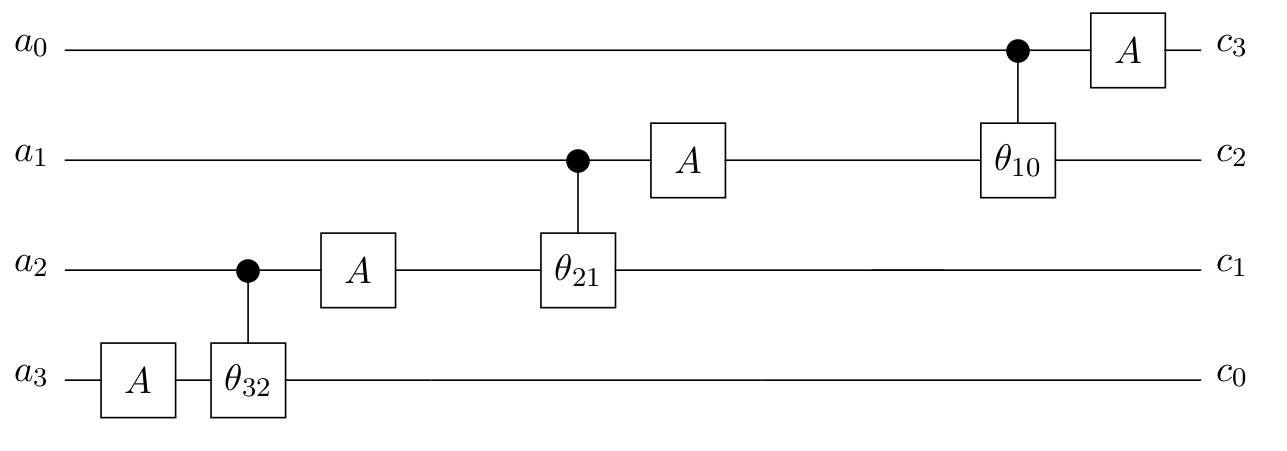Figure 3: Approximate Quantum Fourier Transform [6].










<!-- The implementation of the approximate QFT is illustrated below. -->

In [25]:
def AQft(qc, reg, n):
    """
    Computes the Approximate quantum Fourier transform of reg, one qubit at
    a time.
    Apply one Hadamard gate to the nth qubit of the quantum register reg, and
    then apply a single phase rotation with parameter being pi divided by
    increasing power of two.
    """
    if n == 0:
        return circuit

    qc.h(reg[n])
    for i in range(0, 1):
        qc.cp(math.pi/float(2**(i+1)), reg[n-(i+1)], reg[n])

    qc.draw()

Additionally the computation can be improved by considering that the quantum computer can implement numerous independent gate operations simultaneously, ie parallel. This means that the computation time will decrease resulting in a more accurate computation. A quantum computer capable of computing $\frac{n}{2}$ independent conditioned operations can perform quantum addition in $n+1$ time slices. By eliminating rotations below a certain threshold,this addition can be achieved in $log_2n$ time slices. This parallelism can be achieved by executing same level rotations simultaneously. i.e. depth 1 rotations followed by depth 2 etc [6,7]. The figure below illustrates quantum addition using AQFT and parallelism.

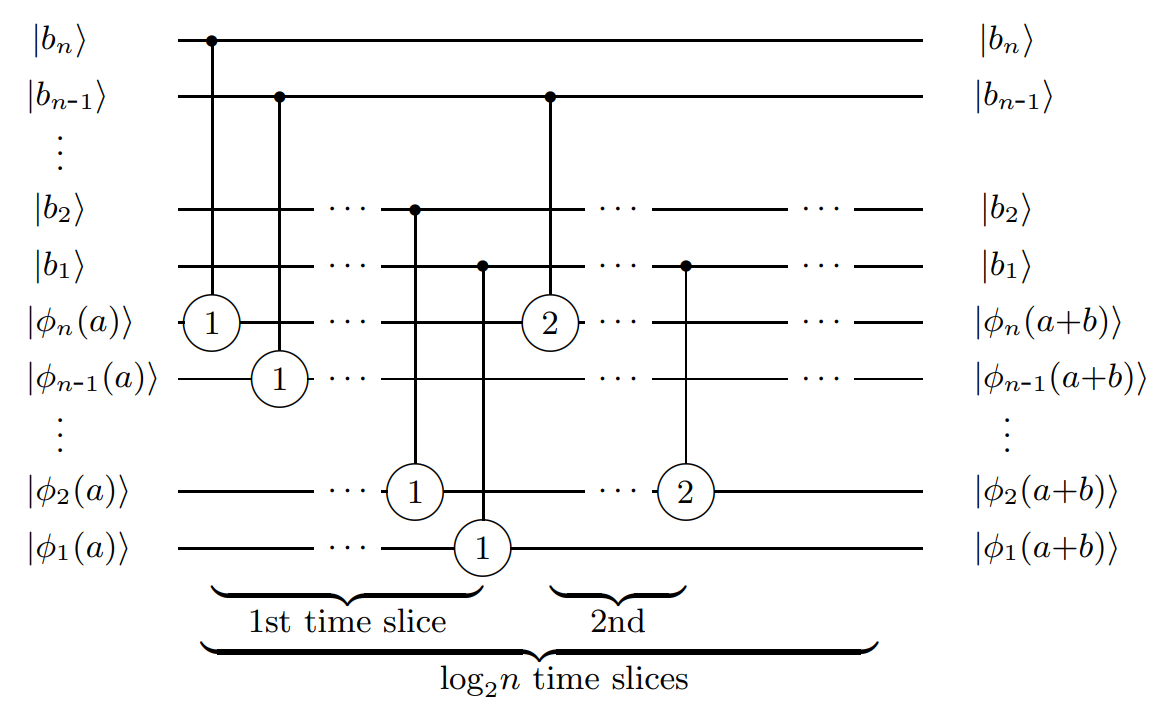Figure 4: Parallel Tranformation Addition [4].


<!-- The implementation of the state evolution is illustrated below. -->

In [26]:
def evolveAQFTState(qc, reg_a, reg_b, n):
    """

    Evolves the state |F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))> using the quantum
    Fourier transform conditioned on the qubits of the reg_b.
    Apply repeated phase rotations with parameters being pi divided by
    increasing powers of two.
    """
    for i in range(0, n+1):
        qc.cp(math.pi/float(2**(i)), reg_b[n-i], reg_a[n])

    qc.draw()

<!-- The modified implementation of the adder is demonstrated below. -->

In [27]:
def AQftAdder(qc, a, b, cl, n):

    for i in range(0, n+1):
        AQft(qc, a, n-i)

    #Add the two numbers by evolving the Fourier transform F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))>
    for i in range(0, n+1):
        evolveAQFTState(qc, a, b, n-i)

    #Compute the inverse Fourier transform of register a
    for i in range(0, n+1):
        inverseQFT(qc, a, i)
        
    #Measure qubits
    circuit = measure(qc, a, cl, n)

    num_shots = 256
    job = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shot = num_shots)
    qasm_result = job.result().get_counts()
    print("The measured Probabilities are:\n")
    print(qasm_result)
    #Select result with maximum probabilities
    print("\nThe result with the maximum probability:\n")

    output = max(qasm_result.items(), key=operator.itemgetter(1))[0]
    print(int(output,2))
    
    return qasm_result
    

# Analysis & Results

The number of gates required to achieve a complete QFT grows as a quadratic function of the size of the register. The transformation of $n$ qubit register requires $n$ operations on $|a\rangle$ and $\frac{n}{2}(n-1)$ on $|b\rangle$ resulting in a total of $\frac{1}{2}n(n+1)$ elementary operations. 

The AQFT of degree $n$, where the gates that act on distant qubits are neglected, $n$ operations are required on $|a\rangle$ and $\frac{1}{2}(2n-log_{2}n)(log_{2}n -1) \approx nlog_{2}n$ on $|b\rangle$ assuming $k$ tends to $log_2n$. By employing the AQFT technique the quantum addition can then be achieved in $log_2n$ time slices [4]. 

> # Simulation

The simulation of the QFT and AQFT adder algorithms for a 5 qubit and 10 qubit are presented. A comparitve analysis of both algorithms conducted on classical and quantum hardware is presented. The scaling and time complexity of the algorithms are analysed. The results are verified using the in-built Qiskit functions. 

>> ## QFT Adder

>> ### 5 Qubit Adder

In [28]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
QFT_Adder_Classic_5 = QftAdder(qc, a, b, cl, n)

Enter first integer number: 0

Enter second integer number: 0

first Number: 0 second Number: 0

The measured Probabilities are:



{'00': 528, '01': 246, '11': 250}



The result with the maximum probability:



0


>> ### 10 Qubit Adder

In [29]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
QFT_Adder_Classic_10 = QftAdder(qc, a, b, cl, n)

Enter first integer number: 0

Enter second integer number: 0

first Number: 0 second Number: 0

The measured Probabilities are:



{'00': 536, '01': 237, '11': 251}



The result with the maximum probability:



0


>> ## AQFT Adder

>> ### 5 AQubit Adder

In [30]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
AQFT_Adder_Classic_5 = AQftAdder(qc, a, b, cl, n)

Enter first integer number: 0

Enter second integer number: 0

first Number: 0 second Number: 0

The measured Probabilities are:



{'00': 518, '01': 234, '11': 272}



The result with the maximum probability:



0


>> ### 10 AQubit Adder

In [31]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
AQFT_Adder_Classic_10 = AQftAdder(qc, a, b, cl, n)

Enter first integer number: 0

Enter second integer number: 0

first Number: 0 second Number: 0

The measured Probabilities are:



{'00': 512, '01': 240, '11': 272}



The result with the maximum probability:



0


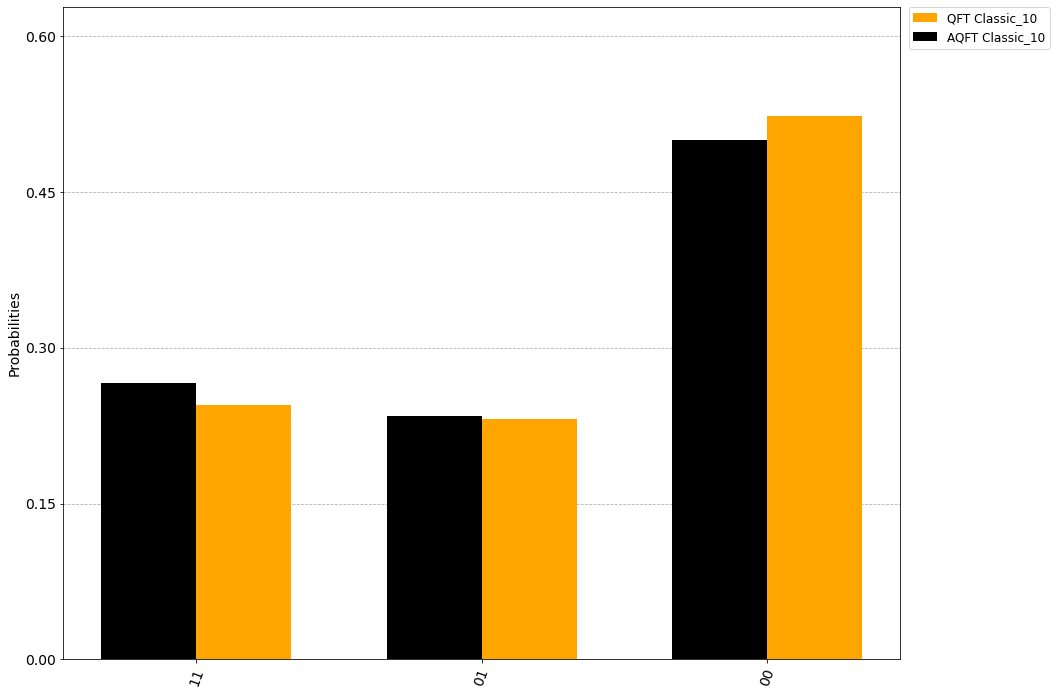

In [32]:
legend = ['QFT Classic_10', 'AQFT Classic_10']
plot_histogram([ QFT_Adder_Classic_10, AQFT_Adder_Classic_10 ], legend=legend,
  sort       = 'desc',
  figsize    = (15,12),
  color      = ['orange', 'black'],
  bar_labels = False)


>> ## Unitary Simulation

In [33]:
ROOT2 = 1/math.sqrt(2)
X = QGate.String("0 1; 1 0")
H = QGate.String("1 1; 1 -1", ROOT2)
I = QGate(np.matrix(np.eye(2)))

>> ## 1 bit Adder

In [ ]:
first_number, second_number = inputRequestClassic()

qft_adder(first_number, second_number)

>> ## 2 bit Adder

In [ ]:
first_number, second_number = inputRequestClassic()

qft_adder(first_number, second_number)

>> ## Quantum Hardware Results

>> ### QFTAdder

In [ ]:
def QftAdder(qc, a, b, cl, n):

    for i in range(0, n+1):
        Qft(qc, a, n-i)

    #Add the two numbers by evolving the Fourier transform F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))>
    for i in range(0, n+1):
        evolveQFTState(qc, a, b, n-i)

    #Compute the inverse Fourier transform of register a
    for i in range(0, n+1):
        inverseQFT(qc, a, i)


    #Measure qubits
    circuit = measure(qc, a, cl, n)

    
    provider = IBMQ.get_provider('ibm-q')

    qcomp = provider.get_backend('ibmq_16_melbourne')

    num_shots = 256
    job = execute(circuit, shots= num_shots, backend = qcomp)

    from qiskit.tools.monitor import job_monitor

    job_monitor(job)
    qasm_result = job.result().get_counts()
    print("The measured Probabilities are:\n")
    print(qasm_result)
    print("\nThe result with the maximum probability:\n")
    output = max(qasm_result.items(), key=operator.itemgetter(1))[0]
    print(int(output,2))
    
    return qasm_result

>> ####  1 bit Adder

In [ ]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
QFT_Adder_Quan_1 = QftAdder(qc, a, b, cl, n)

>> ####  2 bit Adder

In [ ]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
QFT_Adder_Quan_2 = QftAdder(qc, a, b, cl, n)

>> ####  3 bit Adder

In [ ]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
QFT_Adder_Quan_3 = QftAdder(qc, a, b, cl, n)

In [ ]:
legend = ['1 Bit QFT ','2 Bit QFT', '3 Bit QFT']
plot_histogram([QFT_Adder_Quan_1, QFT_Adder_Quan_2, QFT_Adder_Quan_3], legend=legend)

>> ### AQFTAdder

In [ ]:
def AQftAdder(qc, a, b, cl, n):

    for i in range(0, n+1):
        AQft(qc, a, n-i)

    #Add the two numbers by evolving the Fourier transform F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))>
    for i in range(0, n+1):
        evolveAQFTState(qc, a, b, n-i)

    #Compute the inverse Fourier transform of register a
    for i in range(0, n+1):
        inverseQFT(qc, a, i)
        
    #Measure qubits
    circuit = measure(qc, a, cl, n)

    provider = IBMQ.get_provider('ibm-q')

    qcomp = provider.get_backend('ibmq_16_melbourne')

    num_shots = 256
    job = execute(circuit, backend = qcomp)

    from qiskit.tools.monitor import job_monitor

    job_monitor(job)
    qasm_result = job.result().get_counts()
    print("The measured Probabilities are:\n")
    print(qasm_result)
    print("\nThe result with the maximum probability:\n")
    output = max(qasm_result.items(), key=operator.itemgetter(1))[0]
    print(int(output,2))
    
    return qasm_result
    

>> ####  1 bit Adder

In [ ]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
AQFT_Adder_Quan_1 = AQftAdder(qc, a, b, cl, n)

>> ####  2 bit Adder

In [ ]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
AQFT_Adder_Quan_2 = AQftAdder(qc, a, b, cl, n)

>> ####  3 bit Adder

In [ ]:
first_number, second_number, n = inputRequest()
qc, cl, a, b = registerInit(n)
qc, a, b = quSet(first_number, second_number,a, b ,qc)
AQFT_Adder_Quan_3 = AQftAdder(qc, a, b, cl, n)

In [ ]:
legend = ['1 Bit AQFT ','2 Bit AQFT', '3 Bit AQFT']
plot_histogram([AQFT_Adder_Quan_1, AQFT_Adder_Quan_2, AQFT_Adder_Quan_3], legend=legend)

### Combined Results

In [ ]:
# Plot results with legend
legend = ['1 Bit QFT ','1 Bit AQFT', '3 Bit Hardware QFT', '3 Bit Hardware AQFT']
plot_histogram([QFT_Adder_Classic_5, AQFT_Adder_Classic_5,QFT_Adder_Quan_3, AQFT_Adder_Quan_3 ], legend=legend)


# AQFT & Decoherence

A quantum register which is initially prepared in some state and then left on its own will become entangled with the environment as time goes by. The environment introduces phase fluctuations to the qubit states, i.e., it induces random phase fluctuations in the coefficients.  The AQFT implements less gates, by ignoring insignficant rotations,  in the network. Since the state $|b\rangle$ introduces phase fluctuations, the AQFT implementation results in less decoherence errors when compared to the QFT. 

This effect is demonstrated by the simulation results. Better accuracy is achieved using the AQFT. Both implementations suffer more errors as the number of qubits increase. This can be improved by decomposing the gates used to achieve independent operations on qubits. This solution uses more resources but achieves better accuracy.

<!-- This implementation has potential applications in optimizing algorithms such as Shor's algorithm.    -->

# Conclusion and Comments

An analysis of the Quantum Fourier Transform ,and it's approximate conterpart, in the presence of decoherence is presented. The Approximate Quantum Fourier Transform has demonstrated better performance. A further improvement can be achieved by exploiting parallelism by interchanging the order of any two operations which do not involve any of the same qubits. This speeds up the computation time which increases the likelihood of the states maintaining coherence until the computation is complete. Another improvement is decomposing the gates to achieve independent operations on qubits.




# REFERENCES

[1] M. A. Nielsen, I. L. Chuang, Quantum computation and quantum information, 10th Edition, Cambridge University Press, Cambridge, 2010.

[2] V. Vedral, A. Barenco, A. Ekert, “Quantum networks for elementary arithmetic operations”, Phys. Rev. A 54, 147.

[3] A. Steane, “Quantum computing”, quant-ph/9709022.

[4] Michele Mosca and Christof Zalka. “Exact quantum Fourier transforms and discrete logarithm algorithms”. In: Symposium on Foundations of Computer Science (1994). arXiv:quant-ph/0301093 [quant-ph].

[5] Donny Cheung. “Using Generalized Quantum Fourier Transforms in Quantum Phase Estimation
Algorithms”. MA thesis. Waterloo, Ontario, Canada: University of Waterloo, 2003.

[6] R. Cleve et al. “Quantum algorithms revisited”. In: Proceedings of The Royal Society (1998).

[7] Michele Mosca and Christof Zalka. “Exact quantum Fourier transforms and discrete logarithm algorithms”. In: Symposium on Foundations of Computer Science (1994). arXiv:quant-ph/0301093 [quant-ph].